In [74]:
#setup for processed data
#Note: use for BinaryArray data produced from Entrainment_Preprocessing.ipynb
def GetProcessedString(PROCESSING=False):
    if PROCESSING==True:
        Processed_string="PROCESSED_"
    else:
        Processed_string=""
    return Processed_string

PROCESSING=False 
# PROCESSING=True #set to True if using Turbulence-Removed Binary Arrays
Processed_string = GetProcessedString(PROCESSING=PROCESSING)

In [75]:
####################################
#ENVIRONMENT SETUP

In [76]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

In [77]:
#Additional Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import TwoSlopeNorm

In [78]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [79]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType, 
                                             f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz")
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName

def SaveFigure(fig,plotType, fileName):
    plotFileName = f"{fileName}_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
    plottingFileName = GetPlottingDirectory(plotFileName, plotType)
    print(f"Saving figure to {plottingFileName}")
    fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')

In [80]:
#IMPORT CLASSES (from current directory)
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [81]:
#IMPORT FUNCTIONS (from current directory)
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from FUNCTIONS_Variable_Calculation import *

In [82]:
#IMPORT FUNCTIONS

import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

In [83]:
####################################
#LOADING CLASSES

In [84]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="EntrainmentCalculation", dataName="EntrainmentCalculation",
                                dtype='int32')

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Proje

In [85]:
####################################
#FUNCTIONS

In [86]:
#SETTING UP RUN

def LoadMeanLFC():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"MeanLFC_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     MeanLFC = pickle.load(f)
    MeanLFC=2 #*#*
    return MeanLFC
MeanLFC=LoadMeanLFC()
print(f"Mean LFC is: {MeanLFC}\n")


def LoadAllCloudBase():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"all_cloudbase_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     all_cloudbase = pickle.load(f)
    all_cloudbase=1 #*#*
    return(all_cloudbase)
min_all_cloudbase=np.nanmin(LoadAllCloudBase())
cloudbase=min_all_cloudbase
print(f"Minimum Cloudbase is: {cloudbase}\n")

Mean LFC is: 2

Minimum Cloudbase is: 1



In [87]:
#APPLYING ENTRAINMENT CONSTANT
def ApplyEntrainmentConstant(arrayDictionary):
    """
    Multiply each array in the input dictionary by the 1D entrainment constant profile.
    Returns the processed arrays in the same order as the input dictionary.
    """
    entrainmentConstant = DataManager.LoadCalculations(
        DataManager.outputDataDirectory,
        dataName="EntrainmentConstant",
        verbose=False,
    )["entrainmentConstant"]

    outputDictionary = {}
    for var_name, arr in arrayDictionary.items():
        outputDictionary[var_name] = arr * entrainmentConstant[:, np.newaxis, np.newaxis]

    # Return arrays in the same order as input
    return tuple(outputDictionary[var_name] for var_name in arrayDictionary.keys())

# def ApplyEntrainmentConstant(arrayDictionary, vertical_axis=None):
#     """
#     Multiply each array in the input dictionary by the 1D entrainment constant profile.
#     Automatically detects which axis corresponds to the vertical dimension.
#     """
#     # Load entrainment constant
#     entrainmentConstant = DataManager.LoadCalculations(
#         DataManager.outputDataDirectory,
#         dataName="EntrainmentConstant",
#         verbose=False
#     )["entrainmentConstant"]
#     entrainmentConstant = np.asarray(entrainmentConstant)

#     outputDictionary = {}

#     for var_name, arr in arrayDictionary.items():
#         arr = np.asarray(arr)

#         # --- detect vertical axis automatically ---
#         if vertical_axis is None:
#             matches = np.where(np.array(arr.shape) == entrainmentConstant.size)[0]
#             if len(matches) == 0:
#                 raise ValueError(f"No dimension in '{var_name}' matches entrainment constant length {entrainmentConstant.size}")
#             vertical_axis_local = matches[0]
#         else:
#             vertical_axis_local = vertical_axis

#         # --- build correct broadcast shape ---
#         shape = [1] * arr.ndim
#         shape[vertical_axis_local] = entrainmentConstant.size
#         entrainmentConstant_reshaped = entrainmentConstant.reshape(shape)

#         # --- multiply along vertical axis ---
#         outputDictionary[var_name] = arr * entrainmentConstant_reshaped

#         # Debug info
#         # print(f"{var_name}: arr={arr.shape}, const={entrainmentConstant_reshaped.shape}, vertical_axis={vertical_axis_local}")

#     return tuple(outputDictionary[var_name] for var_name in arrayDictionary.keys())


In [88]:
#CALCULATING ENTRAINMENT

PROCESSING=False #*#*
# PROCESSING=True

# def GetEntrainment_T(t,varName):
#     timeString=ModelData.timeStrings[t]
#     output = CallVariable(ModelData, DataManager, timeString, variableName=varName)
#     return output

def GetEntrainment_T(t, varName, cache=None):
    """Load variable for a given timestep, using cached open HDF5 files if available."""
    if cache is None:
        cache = {}

    timeString = ModelData.timeStrings[t]

    # If file for this timestep already in cache, reuse it
    if timeString in cache:
        f = cache[timeString]
    else:
        # Otherwise, open new file and cache it
        f = DataManager.GetTimestepData_V2(DataManager.inputDataDirectory, timeString)
        cache[timeString] = f

    # Load the desired variable from the open file (lazy read)
    if varName in f.keys():
        output = f[varName][:]  # read actual data
    else:
        # fallback for derived variables
        output = CallVariable(ModelData, DataManager, timeString, variableName=varName)
    return output
    
def MeanOut_YX(output):
    output_mean = np.mean(output,axis=(1,2))
    return output_mean

def MeanOut_ZY(output):
    output_mean = np.mean(output,axis=(0,1))
    return output_mean

def MeanOut_ZX(output):
    output_mean = np.mean(output,axis=(0,2))
    return output_mean

def GetEntrainment_Mean(varNames, meantype='TZ',applyconstant=True):
    #defining mean function
    if meantype=='TZ':
        MeanOut = MeanOut_YX
        dim1=ModelData.Ntime
        dim2=ModelData.Nzh
    elif meantype=='TY':
        MeanOut = MeanOut_ZX
        dim1=ModelData.Ntime
        dim2=ModelData.Nyh
    elif meantype=='TX':
        MeanOut = MeanOut_ZY
        dim1=ModelData.Ntime
        dim2=ModelData.Nxh
        
    outputDict = {name: np.zeros((dim1, dim2), dtype=np.float32) for name in varNames}
    loaded_cache = {} #cache for loaded datasets
    try:
        for t in range(ModelData.Ntime):
            if np.mod(t,10)==0: print(f'Current time {t}')
    
            for varName in varNames:
                if 'Detrainment' in varName and t == ModelData.Ntime-1:
                    continue
                else:
                    variable = GetEntrainment_T(t,varName,cache=loaded_cache)
                    if applyconstant==True:
                        (variable,) = ApplyEntrainmentConstant({"variable": variable})
                    variableMean = MeanOut(variable)
                    outputDict[varName][t] = variableMean

    finally:
        # Closing all h5py handles
        for key, f in loaded_cache.items():
            try:
                f.close()
            except Exception as e:
                print(f"Warning: failed to close file {key}: {e}")

    return outputDict


def GetEntrainment_MeanZX(varNames, meantype='ZX',applyconstant=True):
    """
    Compute the mean over time and Y for each variable in varNames.
    Returns a dictionary with shape (zh, xh) for each variable.
    """
    outputDict = {name: np.zeros((ModelData.Nzh, ModelData.Nxh), dtype=np.float32) for name in varNames}
    loaded_cache = {}

    try:
        for t in range(ModelData.Ntime):
            if np.mod(t, 10) == 0:
                print(f'Current time {t}')

            for varName in varNames:
                if 'Detrainment' in varName and t == ModelData.Ntime - 1:
                    continue
                else:
                    variable = GetEntrainment_T(t, varName, cache=loaded_cache)
                    if applyconstant==True:
                        (variable,) = ApplyEntrainmentConstant({"variable": variable})

                    # Average over y-axis (axis=2), result shape: (zh, xh)
                    yz_mean = np.mean(variable, axis=1)

                    # Accumulate over time
                    outputDict[varName] += yz_mean

        # Final average over time
        for varName in varNames:
            # Detrainment is one timestep shorter
            nt = ModelData.Ntime - 1 if 'Detrainment' in varName else ModelData.Ntime
            outputDict[varName] /= nt

    finally:
        # Close all open HDF5 handles
        for key, f in loaded_cache.items():
            try:
                f.close()
            except Exception as e:
                print(f"Warning: failed to close file {key}: {e}")

    return outputDict


In [89]:
####################################
#CALCULATION FUNCTIONS

In [93]:
#entrainmentdetrainment

def Calculate_EntrainmentDetrainment_Mean(meantype='TZ'):  
    if meantype=='ZX':
        GetEntrainment_Mean_Function = GetEntrainment_MeanZX
    else:
        GetEntrainment_Mean_Function = GetEntrainment_Mean
        
    #loading/calculation data
    try:
        # Try loading existing calculations
        arrayDictionary = DataManager.LoadCalculations(
            DataManager.outputDataDirectory,
            dataName=f"{Processed_string}EntrainmentDetrainment_Mean{meantype}"
        )
        print(arrayDictionary.keys())
    except Exception as e:
        print("Loading failed. Running calculations and saving.")
        print("Error:", e)

        varNames = [f"{Processed_string}Entrainment_g",
                    f"{Processed_string}Entrainment_c",
                    f"{Processed_string}Detrainment_g",
                    f"{Processed_string}Detrainment_c"]
        arrayDictionary = GetEntrainment_Mean_Function(varNames,meantype,applyconstant=True)
    
        #SAVING
        DataManager.SaveCalculations(DataManager.outputDataDirectory, arrayDictionary, dataName=f"{Processed_string}EntrainmentDetrainment_Mean{meantype}",dtype="float32")

    a, b, c, d = (
        arrayDictionary[k] for k in [f"{Processed_string}Entrainment_g", 
                                     f"{Processed_string}Entrainment_c", 
                                     f"{Processed_string}Detrainment_g", 
                                     f"{Processed_string}Detrainment_c"]
    )
    return [a,
            b,
            c,
            d]

#entrainmentdetrainment

def Calculate_TransferEntrainmentDetrainment_Mean(meantype='TZ'):  
    if meantype=='ZX':
        GetEntrainment_Mean_Function = GetEntrainment_MeanZX
    else:
        GetEntrainment_Mean_Function = GetEntrainment_Mean
        
    #loading/calculation data
    try:
        # Try loading existing calculations
        arrayDictionary = DataManager.LoadCalculations(
            DataManager.outputDataDirectory,
            dataName=f"{Processed_string}TransferEntrainmentDetrainment_Mean{meantype}"
        )
        print(arrayDictionary.keys())
    except Exception as e:
        print("Loading failed. Running calculations and saving.")
        print("Error:", e)

        varNames = [f"{Processed_string}TransferEntrainment_g",
                    f"{Processed_string}TransferEntrainment_c",
                    f"{Processed_string}TransferDetrainment_g",
                    f"{Processed_string}TransferDetrainment_c"]
        arrayDictionary = GetEntrainment_Mean_Function(varNames,meantype,applyconstant=True)
    
        #SAVING
        DataManager.SaveCalculations(DataManager.outputDataDirectory, arrayDictionary, dataName=f"{Processed_string}TransferEntrainmentDetrainment_Mean{meantype}",dtype="float32")

    a, b, c, d = (
        arrayDictionary[k] for k in [f"{Processed_string}TransferEntrainment_g", f"{Processed_string}TransferEntrainment_c", f"{Processed_string}TransferDetrainment_g", f"{Processed_string}TransferDetrainment_c"]
    )
    return [a,
            b,
            c,
            d]

In [94]:
####################################
#CALCULATION

In [95]:
#entrainmentdetrainment
[profile_array_e_g_MeanTZ,
 profile_array_e_c_MeanTZ,
 profile_array_d_g_MeanTZ,
 profile_array_d_c_MeanTZ] = Calculate_EntrainmentDetrainment_Mean(meantype='TZ')

#transfer entrainmentdetrainment
[TransferEntrainment_g_MeanTZ,
 TransferEntrainment_c_MeanTZ,
 TransferDetrainment_g_MeanTZ,
 TransferDetrainment_c_MeanTZ] = Calculate_TransferEntrainmentDetrainment_Mean(meantype='TZ')

Loading failed. Running calculations and saving.
Error: [Errno 2] Unable to open file (unable to open file: name = '/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrdainmentDetrainment_MeanTZ_1km_5min_34nz.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Saved calculations to output file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrainmentDetrainment_MeanTZ_1km_5min_34nz.h5 

Loading failed. Running calculations and saving.
Error: [Errno 2] Unable to open file (unable

In [96]:
#entrainmentdetrainment
[profile_array_e_g_MeanTY,
 profile_array_e_c_MeanTY,
 profile_array_d_g_MeanTY,
 profile_array_d_c_MeanTY] = Calculate_EntrainmentDetrainment_Mean(meantype='TY')

Loading failed. Running calculations and saving.
Error: [Errno 2] Unable to open file (unable to open file: name = '/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrdainmentDetrainment_MeanTY_1km_5min_34nz.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Saved calculations to output file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrainmentDetrainment_MeanTY_1km_5min_34nz.h5 



In [97]:
#entrainmentdetrainment
[profile_array_e_g_MeanTX,
 profile_array_e_c_MeanTX,
 profile_array_d_g_MeanTX,
 profile_array_d_c_MeanTX] = Calculate_EntrainmentDetrainment_Mean(meantype='TX')

Loading failed. Running calculations and saving.
Error: [Errno 2] Unable to open file (unable to open file: name = '/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrdainmentDetrainment_MeanTX_1km_5min_34nz.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Saved calculations to output file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrainmentDetrainment_MeanTX_1km_5min_34nz.h5 



In [98]:
#entrainmentdetrainment
[profile_array_e_g_MeanZX,
 profile_array_e_c_MeanZX,
 profile_array_d_g_MeanZX,
 profile_array_d_c_MeanZX] = Calculate_EntrainmentDetrainment_Mean(meantype='ZX')

Loading failed. Running calculations and saving.
Error: [Errno 2] Unable to open file (unable to open file: name = '/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrdainmentDetrainment_MeanZX_1km_5min_34nz.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Saved calculations to output file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/PROCESSED_EntrainmentDetrainment_MeanZX_1km_5min_34nz.h5 



In [99]:
####################################
#PLOTTING FUNCTIONS

In [100]:
def GetData_Mean(type,meantype='TZ'):
    if type=='general':
        profile_array_e=globals()[f"profile_array_e_g_Mean{meantype}"]
        profile_array_d=-globals()[f"profile_array_d_g_Mean{meantype}"]
        profile_array_net=profile_array_e-profile_array_d
    if type=='cloudy':
        profile_array_e=globals()[f"profile_array_e_c_Mean{meantype}"]
        profile_array_d=-globals()[f"profile_array_d_c_Mean{meantype}"]
        profile_array_net=profile_array_e-profile_array_d

    return profile_array_e,profile_array_d,profile_array_net

def GetTransferData_Mean(meantype='TZ'):
    TransferEntrainment_g_Mean=globals()[f"TransferEntrainment_g_Mean{meantype}"]
    TransferEntrainment_c_Mean=globals()[f"TransferEntrainment_c_Mean{meantype}"]
    TransferDetrainment_g_Mean=globals()[f"TransferDetrainment_g_Mean{meantype}"]
    TransferDetrainment_c_Mean=globals()[f"TransferDetrainment_c_Mean{meantype}"]
    return TransferEntrainment_g_Mean,TransferEntrainment_c_Mean, TransferDetrainment_g_Mean,TransferDetrainment_c_Mean

In [101]:
def plot_mean_entrainment(ax, profile_array_e, profile_array_d, title, linestyle='solid'):
    zh=ModelData.zh

    # Compute mean profiles
    e = np.mean(profile_array_e, axis=0)
    d = np.mean(profile_array_d, axis=0)
    net = np.mean(profile_array_e - profile_array_d, axis=0)

    # Plot
    ax.plot(e, zh, linestyle=linestyle, color='blue', label='Entrainment')
    ax.plot(d, zh, linestyle=linestyle, color='red', label='Detrainment')
    ax.plot(net, zh, linestyle=linestyle, color='black', label='Net Entrainment')
    ax.axvline(0, color='gray', linestyle='dashed',zorder=-10)

    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC, color='green', linestyle='dashed', lw=1.2)

    ax.grid(True)
    ax.set_title(f"{title}",fontsize=10.5)
    ax.set_xlabel(r"($kg\ m^{-3}\ s^{-1}$)")  
    ax.set_ylabel('z (km)')
    ax.set_ylim(bottom=0)
    ax.legend(loc='upper right')
    ax.set_ylim(0,20)

    #FIXED TICKS
    SnapLimitsToTicks([ax], dim='x')

    
    # Format x-axis in scientific notation
    apply_scientific_notation([ax],decimals=2)

In [102]:
#functions for transfer entrainment calculations

# def nandivide(numerator_array, denominator_array):
#     """
#     Performs element-wise division returning NaN where denominator == 0.
#     """
#     return np.where(denominator_array == 0, np.nan, numerator_array / denominator_array)
def nandivide(numerator_array, denominator_array):
    """
    Performs element-wise division returning NaN where denominator == 0.
    Silently ignores divide-by-zero and invalid operation warnings.
    """
    numerator_array = np.asarray(numerator_array, dtype=float)
    denominator_array = np.asarray(denominator_array, dtype=float)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(denominator_array == 0, np.nan, numerator_array / denominator_array)
    
    return result


TransferEntrainment_Ratio = nandivide(TransferEntrainment_c_MeanTZ,profile_array_e_c_MeanTZ).astype("float32")

def ComputeAverageProfiles(input_dict):
    output_dict = {}
    for key, arr in input_dict.items():
        output_dict[key] = np.nanmean(arr, axis=0)
    return output_dict

    
def plot_transfer_rate(ax, means, title):
    zh = ModelData.zh

    a = means['TransferEntrainment_c_Mean']
    b = means['TransferEntrainment_g_Mean']
    c = means['TransferDetrainment_c_Mean']
    d = means['TransferDetrainment_g_Mean']

    ax.plot(a, zh, color='green', label='General → Cloudy Entrainment')
    ax.plot(b, zh, color='orange', label='Cloudy → General Entrainment')
    ax.plot(c, zh, color='blue', label='Cloudy → General Detrainment')
    ax.plot(d, zh, color='red', label='General → Cloudy Detrainment')

    ax.axvline(0, color='black', linestyle='dashed', linewidth=1)
    # ax.axvline(1, color='black', linestyle='dashed', linewidth=1)
    ax.axvline(100, color='black', linestyle='dashed', linewidth=1)
    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC, color='green', linestyle='dashed', lw=1.2)

    # Aesthetics
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(r"($kg\,m^{-3}\,s^{-1}$)")
    ax.set_ylabel('z (km)')
    ax.set_ylim(bottom=0, top=20)
    ax.legend(fontsize=10, loc='center right')

    SnapLimitsToTicks([ax], dim='x')
    apply_scientific_notation([ax], decimals=2)


def plot_transfer_ratio(ax, means, title):
    zh = ModelData.zh
    
    ratio1 = nandivide(means['TransferEntrainment_c_Mean'],means['profile_array_e_c'])
    ratio2 = nandivide(means['TransferEntrainment_g_Mean'],means['profile_array_e_g'])
    ratio3 = nandivide(means['TransferDetrainment_c_Mean'],means['profile_array_d_c'])
    ratio4 = nandivide(means['TransferDetrainment_g_Mean'],means['profile_array_d_g'])

    ax.plot(ratio1*100, zh, color='green', label='General → Cloudy / Cloudy Entrainment')
    ax.plot(ratio2*100, zh, color='orange', label='Cloudy → General / General Entrainment')
    ax.plot(ratio3*100, zh, color='blue', label='Cloudy → General / General Detrainment')
    ax.plot(ratio4*100, zh, color='red', label='General → Cloudy / Cloudy Detrainment')

    ax.axvline(0, color='black', linestyle='dashed', linewidth=1)
    # ax.axvline(1, color='black', linestyle='dashed', linewidth=1)
    ax.axvline(100, color='black', linestyle='dashed', linewidth=1)
    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC, color='green', linestyle='dashed', lw=1.2)

    ax.grid(True)
    ax.set_title(f"{title}")
    # ax.set_xlabel('Ratio')
    ax.set_xlabel('%')
    ax.set_ylabel('z (km)')
    # ax.set_xlim(-0.05, 1.05)
    ax.set_xlim(-5, 105)
    ax.set_ylim(bottom=0,top=20)
    ax.legend(fontsize=10.5-3, loc='center right')
    # apply_scientific_notation([ax])

In [103]:
def Plot_EntrainmentDetrainmentRows_Mean(array_triplets, type_labels, plotting=True, meantype='TZ'):
    if not plotting:
        return
        
    cmap1 = plt.cm.viridis
    cmap2 = plt.cm.seismic 
    n_levels = 29

    num_rows = len(array_triplets)

    fig = plt.figure(figsize=(18, 4 * num_rows))
    gs = GridSpec(num_rows, 4, figure=fig)
    all_ax1, all_ax2, all_ax3 = [], [], []
    
    for row_idx, ((profile_array_e, profile_array_d, profile_array_net), type_label) in enumerate(zip(array_triplets, type_labels)):
        # vmax_shared = np.max([np.max(profile_array_e), np.max(profile_array_d)])
        # norm_shared = mcolors.Normalize(vmin=0, vmax=vmax_shared)
        norm_shared = None

        if meantype == 'TZ':
            x = np.arange(profile_array_e.shape[0])
            x_label = "t (hours)"

            y = ModelData.zh
            y_label = "z (km)"
            y_lim = (np.min(ModelData.zh), np.max(ModelData.zh))
            # y_lim = tuple(np.round(y_lim, 0))

        if meantype == 'TY':
            x = np.arange(profile_array_e.shape[0])
            x_label = "t (hours)"
            y = ModelData.yh
            y_label = "y (km)"
            y_lim = (np.min(ModelData.yh), np.max(ModelData.yh))
            # y_lim = tuple(np.round(y_lim, 0))
        elif meantype == 'TX':
            x = np.arange(profile_array_e.shape[0])
            x_label = "t (hours)"
            y = ModelData.xh
            y_label = "x (km)"
            y_lim = (np.min(ModelData.xh), np.max(ModelData.xh))
            # y_lim = tuple(np.round(y_lim, 0))
        elif meantype == 'ZX':
            x = ModelData.xh
            x_label = "x (km)"
            y = ModelData.zh
            y_label = "z (km)"
            y_lim = (np.min(ModelData.zh), np.max(ModelData.zh))
            # y_lim = tuple(np.round(y_lim, 0))        
        mins=(ModelData.time[1].astype(int)/1e9/60)
        xTickInterval = 60/mins
        plot_kwargs = {
            'PlotData': None,
            'xTickLabels': x, 'yTickLabels': y,
            'contour_type': 'line',#'fill',
            # 'contour_type': 'fill',
            'num_xticks': 11, 'round_xticks': None, 'xTickInterval': xTickInterval,
            'num_yticks': 15, 'round_yticks': 2, 'yTickInterval': None,
            'add_colorbar': True, 'fig': fig, 'levels': 29, 'colorbar_label_rotation': 0, 'colorbar_label': None,
            'xlabel': x_label, 'ylabel': y_label,
            'solid_contour_labels': False, 'solid_contour_round': None,
            'xtick_rotation': 0, 'ytick_rotation': 0, 'cbar_rotation': 0,
            'save_path': None, 'save_dpi': 300,
            'colorbar_kwargs': {
                'extend': 'both'
            },
            'norm': norm_shared
        }

        ax1 = fig.add_subplot(gs[row_idx, 0])
        ax2 = fig.add_subplot(gs[row_idx, 1])
        ax3 = fig.add_subplot(gs[row_idx, 2])

        all_ax1.append(ax1)
        all_ax2.append(ax2)
        all_ax3.append(ax3)

        plot_kwargs1 = plot_kwargs.copy()
        plot_kwargs1['PlotData'] = profile_array_e.copy().T
        plot_kwargs1['cmap'] = cmap1
        [contour1, cbar1] = UltimateContourPlot(ax1, **plot_kwargs1)
        ax1.set_ylim(y_lim)
        ax1.set_title(f'Entrainment {type_label}',fontsize=8)

        plot_kwargs2 = plot_kwargs.copy()
        plot_kwargs2['PlotData'] = profile_array_d.copy().T
        plot_kwargs2['cmap'] = cmap1
        [contour2, cbar2] = UltimateContourPlot(ax2, **plot_kwargs2)
        ax2.set_ylim(y_lim)
        ax2.set_title(f'Detrainment {type_label}',fontsize=8)

        plot_data3 = profile_array_net.copy().T

        #FIXING COLORBAR NORM
        #####################   
        # vmin = -np.max(abs(profile_array_net)) / 2
        # vmax = +np.max(abs(profile_array_net))
        # levels = np.linspace(vmin, vmax, n_levels)
        # norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
            
        vmin = np.min(profile_array_net)
        vmax = np.max(profile_array_net)
        vcenter = 0.0
        levels = np.linspace(vmin, vmax, n_levels)
        norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        #####################
        
        plot_kwargs3 = plot_kwargs.copy()
        plot_kwargs3['PlotData'] = plot_data3
        plot_kwargs3['cmap'] = cmap2
        plot_kwargs3['norm'] = norm
        plot_kwargs3['levels'] = levels
        [contour3, cbar3] = UltimateContourPlot(ax3, **plot_kwargs3)
        ax3.set_ylim(y_lim)
        ax3.set_title(f'Net Entrainment {type_label}',fontsize=8)
        # fig.suptitle(f"{type_labels[row_idx][0].upper() + type_labels[row_idx][1:]} Updraft Entrainment/Detrainment")

        def apply_scientific_notation_colorbar(cbars):
            from matplotlib.ticker import ScalarFormatter
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((-2, 2))
            for cbar in cbars:
                cbar.formatter = formatter
                cbar.update_ticks()

        apply_scientific_notation_colorbar([cbar1, cbar2, cbar3])

        #FIXING CONTOUR COLORBAR LINES THICKNESS
        for cbar in [cbar1, cbar2, cbar3]:
            for cbar_line in cbar.ax.collections:
                cbar_line.set_linewidth(3)
        if meantype=='TZ':
            for ax in [ax1,ax2,ax3]:
                ax.axhline(cloudbase, color='purple', linestyle='dashed',lw=1.2)
                ax.axhline(MeanLFC, color='green', linestyle='dashed',lw=1.2)
        if meantype!='ZX':
            for ax in [ax1,ax2,ax3]:
                xticks = ax.get_xticks()
                new_labels = [f"{tick*mins/(60)+6:.0f}" for tick in xticks]
                ax.set_xticklabels(new_labels)
        if meantype == 'ZX':
            num_xticks = 4
            x_indices = np.linspace(0, len(x)-1, num_xticks, dtype=int)
            x_ticks = x[x_indices]
            for ax in [ax1, ax2, ax3]:
                ax.set_xticks(x_ticks)
                ax.set_xticklabels([f"{val:.1f}" for val in x_ticks])
            
    ticks = np.linspace(y_lim[0], y_lim[1], num=11)
    for ax in all_ax1 + all_ax2 + all_ax3:# + [ax4, ax5]:
        ax.set_ylim(y_lim)
        ax.set_yticks(ticks)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.margins(y=0)

    if meantype=='TZ':
        ax4 = fig.add_subplot(gs[0, 3])
        ax5 = fig.add_subplot(gs[1, 3])
        plot_mean_entrainment(ax4, profile_array_e1, profile_array_d1, title='Mean Vertical Profile')
        plot_mean_entrainment(ax5, profile_array_e2, profile_array_d2, title='Mean Vertical Profile')

    #SPACING
    fig.subplots_adjust(top=0.92, wspace=0.4, hspace=0.4)
    
    return fig

In [104]:
####################################
#PLOTTING

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/PROCESSED_EntrainmentDetrainment_MeanTZ_1km_5min_1e6.jpg


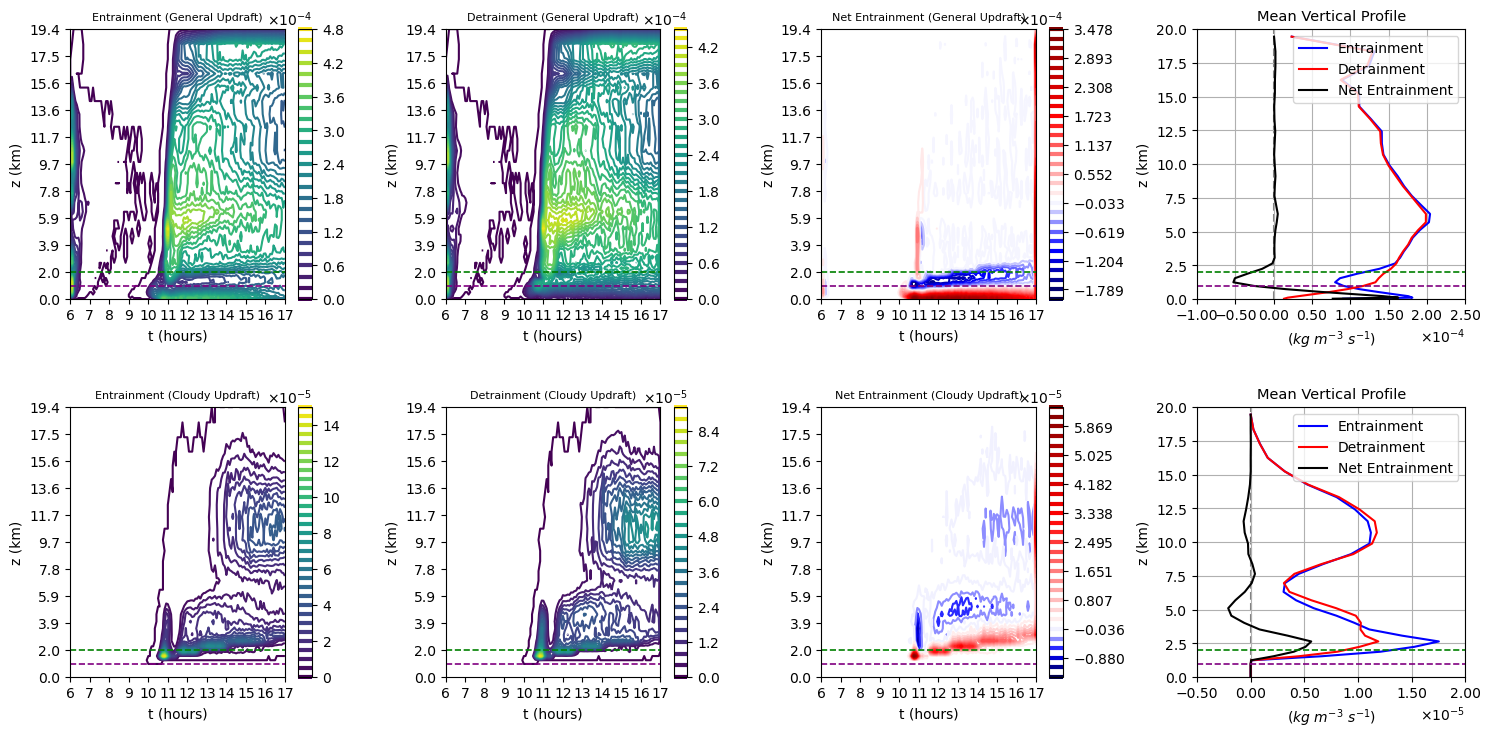

In [105]:
meantype='TZ'

#LOAD DATA
type1='general';type2='cloudy'
[profile_array_e1,profile_array_d1,profile_array_net1]=GetData_Mean(type=type1,meantype=meantype)
[profile_array_e2,profile_array_d2,profile_array_net2]=GetData_Mean(type=type2,meantype=meantype)

#CONTOUR PLOTS
array_triplets = [
    (profile_array_e1, profile_array_d1, profile_array_net1),
    (profile_array_e2, profile_array_d2, profile_array_net2)
]
type_labels = ['(General Updraft)', '(Cloudy Updraft)']

fig = Plot_EntrainmentDetrainmentRows_Mean(array_triplets, type_labels, meantype=meantype)

#SAVING 
fileName=f"{Processed_string}EntrainmentDetrainment_MeanTZ" 
SaveFigure(fig,plotType="Variable_Calculation/EntrainmentCalculation",fileName=fileName)

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/PROCESSED_EntrainmentDetrainment_MeanTY_1km_5min_1e6.jpg


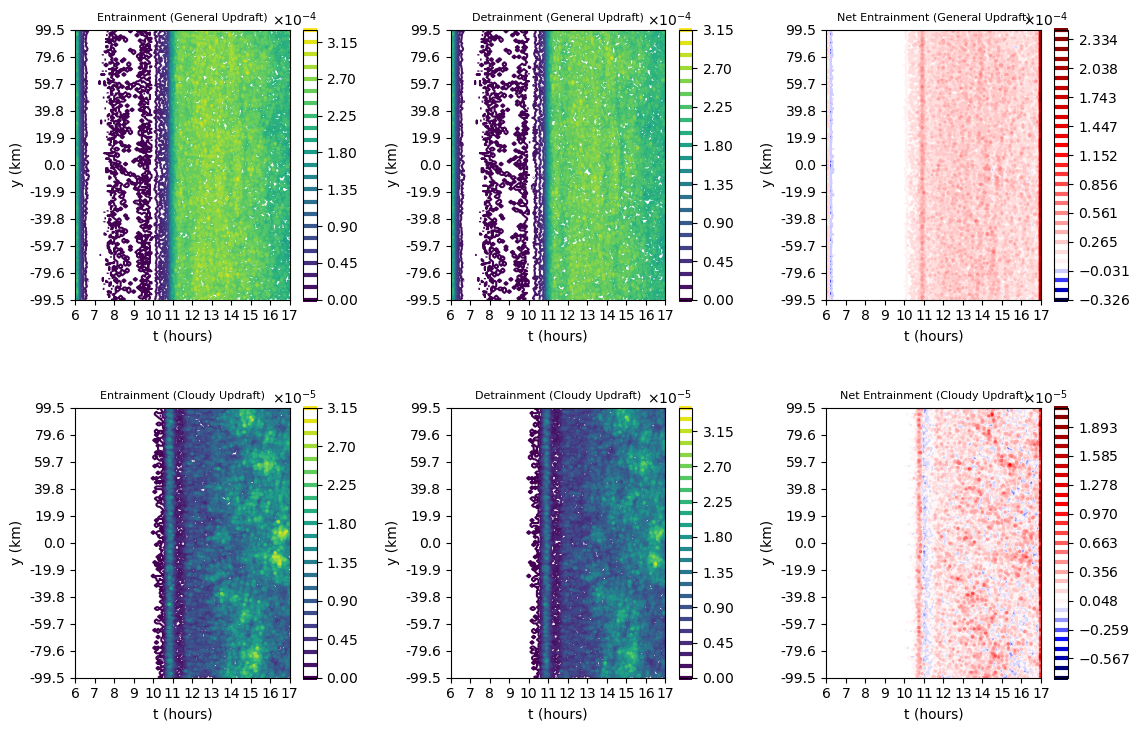

In [106]:
meantype='TY'

#LOAD DATA
type1='general';type2='cloudy'
[profile_array_e1,profile_array_d1,profile_array_net1]=GetData_Mean(type=type1,meantype=meantype)
[profile_array_e2,profile_array_d2,profile_array_net2]=GetData_Mean(type=type2,meantype=meantype)

#CONTOUR PLOTS
array_triplets = [
    (profile_array_e1, profile_array_d1, profile_array_net1),
    (profile_array_e2, profile_array_d2, profile_array_net2)
]
type_labels = ['(General Updraft)', '(Cloudy Updraft)']

fig = Plot_EntrainmentDetrainmentRows_Mean(array_triplets, type_labels, meantype=meantype)

#SAVING 
fileName=f"{Processed_string}EntrainmentDetrainment_MeanTY" 
SaveFigure(fig,plotType="Variable_Calculation/EntrainmentCalculation",fileName=fileName)

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/PROCESSED_EntrainmentDetrainment_MeanTX_1km_5min_1e6.jpg


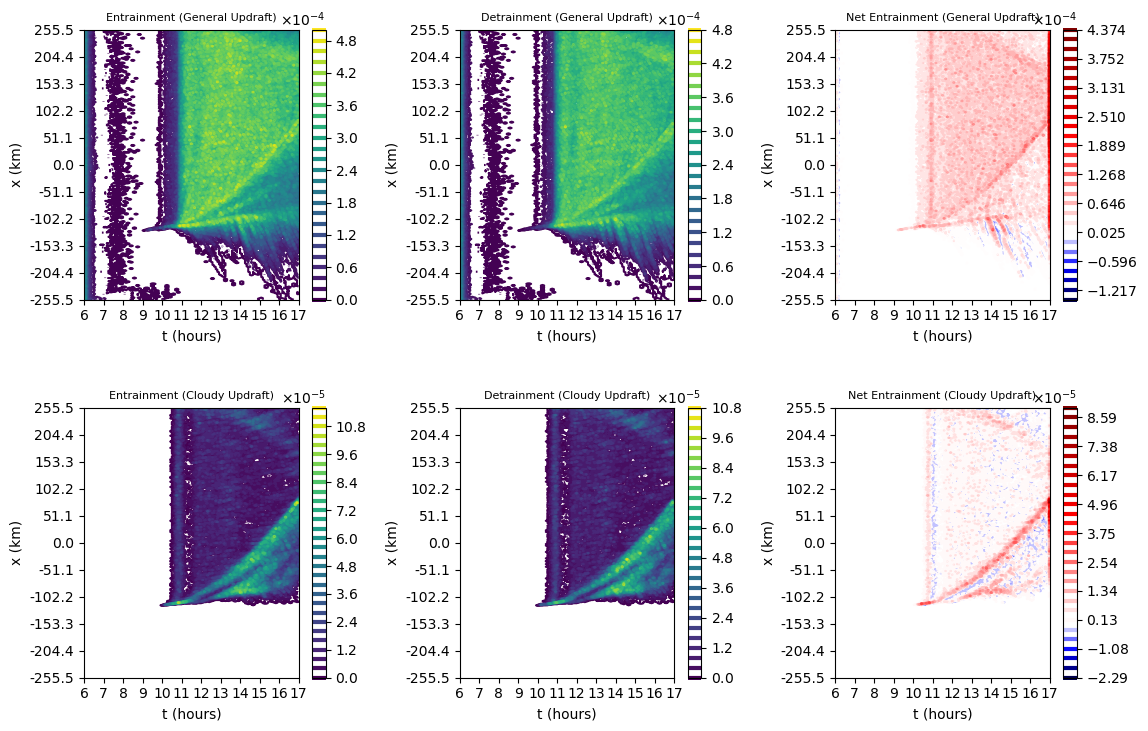

In [107]:
meantype='TX'

#LOAD DATA
type1='general';type2='cloudy'
[profile_array_e1,profile_array_d1,profile_array_net1]=GetData_Mean(type=type1,meantype=meantype)
[profile_array_e2,profile_array_d2,profile_array_net2]=GetData_Mean(type=type2,meantype=meantype)

#CONTOUR PLOTS
array_triplets = [
    (profile_array_e1, profile_array_d1, profile_array_net1),
    (profile_array_e2, profile_array_d2, profile_array_net2)
]
type_labels = ['(General Updraft)', '(Cloudy Updraft)']

fig = Plot_EntrainmentDetrainmentRows_Mean(array_triplets, type_labels, meantype=meantype)

#SAVING 
fileName=f"{Processed_string}EntrainmentDetrainment_MeanTX" 
SaveFigure(fig,plotType="Variable_Calculation/EntrainmentCalculation",fileName=fileName)

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/PROCESSED_EntrainmentDetrainment_MeanZX_1km_5min_1e6.jpg


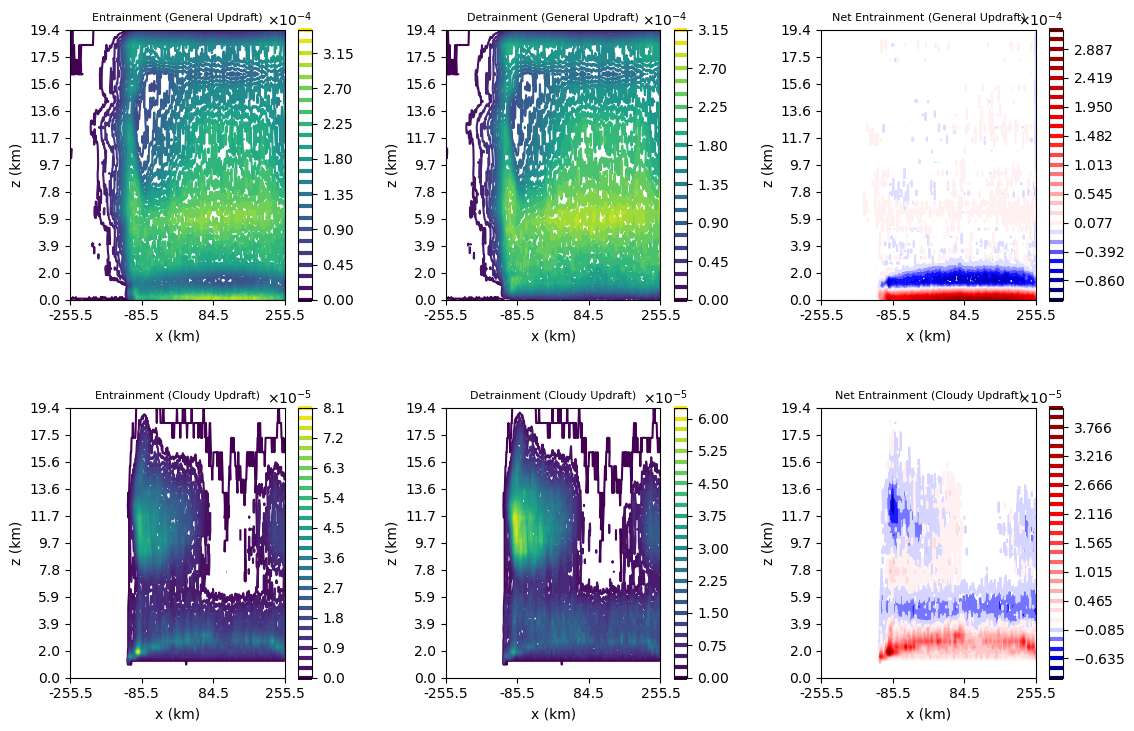

In [108]:
meantype='ZX'

#LOAD DATA
type1='general';type2='cloudy'
[profile_array_e1,profile_array_d1,profile_array_net1]=GetData_Mean(type=type1,meantype=meantype)
[profile_array_e2,profile_array_d2,profile_array_net2]=GetData_Mean(type=type2,meantype=meantype)

#CONTOUR PLOTS
array_triplets = [
    (profile_array_e1.T, profile_array_d1.T, profile_array_net1.T),
    (profile_array_e2.T, profile_array_d2.T, profile_array_net2.T)
]
type_labels = ['(General Updraft)', '(Cloudy Updraft)']

fig = Plot_EntrainmentDetrainmentRows_Mean(array_triplets, type_labels, meantype=meantype)

#SAVING 
fileName=f"{Processed_string}EntrainmentDetrainment_MeanZX" 
SaveFigure(fig,plotType="Variable_Calculation/EntrainmentCalculation",fileName=fileName)

In [109]:
#COMBINED ENTRAINMENT

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/PROCESSED_TransferEntrainmentDetrainment_1km_5min_1e6.jpg


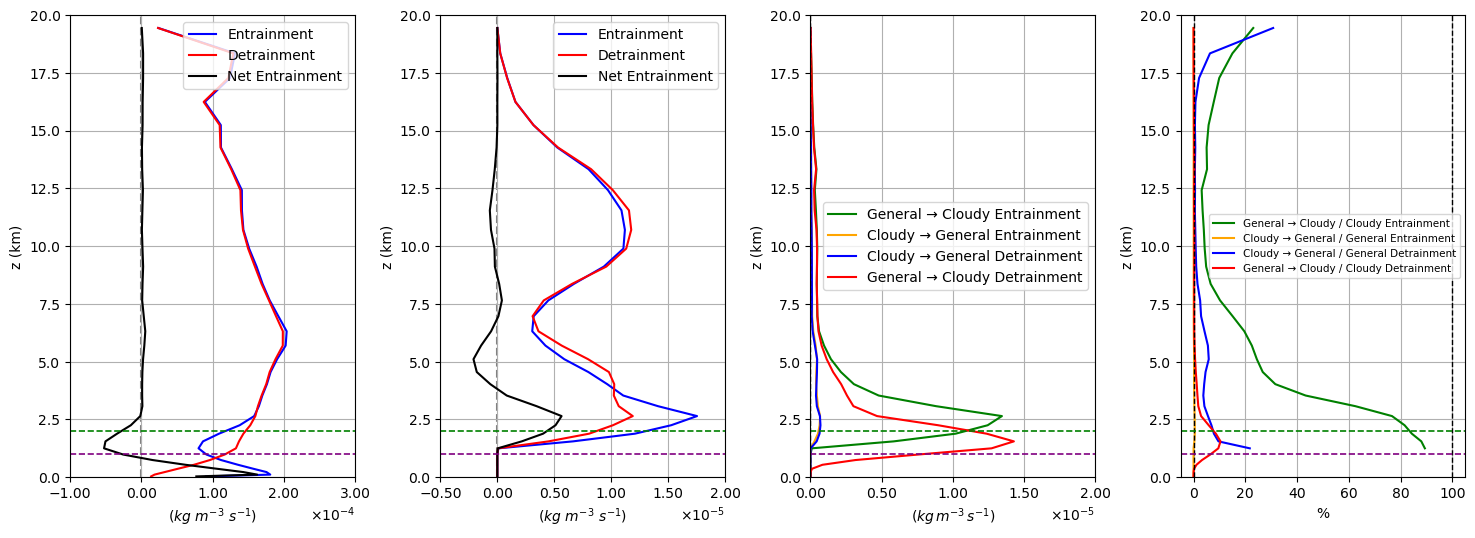

In [112]:
# === Compute means for transfer rate and ratio plots ===
meantype='TZ'

#LOAD DATA
type1='general';type2='cloudy'
[profile_array_e_g,profile_array_d_g,profile_array_net_g]=GetData_Mean(type=type1,meantype=meantype)
[profile_array_e_c,profile_array_d_c,profile_array_net_c]=GetData_Mean(type=type2,meantype=meantype)

[TransferEntrainment_g_Mean,TransferEntrainment_c_Mean,
    TransferDetrainment_g_Mean,TransferDetrainment_c_Mean] = GetTransferData_Mean()

profilesDictionary = {
    "profile_array_e_g": profile_array_e_g,
    "profile_array_d_g": profile_array_d_g,
    "profile_array_net_g": profile_array_net_g,

    "profile_array_e_c": profile_array_e_c,
    "profile_array_d_c": profile_array_d_c,
    "profile_array_net_c": profile_array_net_c,
    
    "TransferEntrainment_g_Mean": TransferEntrainment_g_Mean,
    "TransferEntrainment_c_Mean": TransferEntrainment_c_Mean,
    "TransferDetrainment_g_Mean": TransferDetrainment_g_Mean,
    "TransferDetrainment_c_Mean": TransferDetrainment_c_Mean
}

means = ComputeAverageProfiles(profilesDictionary)

# === Set up figure and subplots ===
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 4, figure=fig, wspace=0.3, )


ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# === Plot each panel ===
plot_mean_entrainment(ax1, profile_array_e_g, profile_array_d_g, title='')
plot_mean_entrainment(ax2, profile_array_e_c, profile_array_d_c, title='')
plot_transfer_rate(ax3, means, title='')
plot_transfer_ratio(ax4, means, title='')
# fig.subplots_adjust(top=0.92, wspace=0.4, hspace=0.4)

#SAVING 
fileName=f"{Processed_string}TransferEntrainmentDetrainment" 
SaveFigure(fig,plotType="Variable_Calculation/EntrainmentCalculation",fileName=fileName)